# МатСтат. Практика 5. Выделение трендов
В папке два файла, которые содержат разные временные ряды. В первом файле находится ряд с синусоидальным трендом. Во втором - с линейным.  
Необходимо выделить тренд используя 4 метода:
1. Простое скользящее среднее (SMA)
2. Взвешенное скользящее среднее (WMA) особого типа (как обсуждалось на лекции)
3. Экспоненциальное сглаживание (EMA)
4. Двойное экспоненциальное сглаживание (DEMA)

Каждые метод требует подбора некоторых параметров:  
*SMA* и *WMA* - размер окна, *EMA* - параметр сглаживания A,  
*DEMA* - параметр сглаживания вокруг тренда A и параметр сглаживания самого тренда B.

Необходимо подобрать оптимальные значения соотвествующих параметров, используя *Q-статистику Льюнг-Бокса* при m = 5.  Оптимальными параметрами будем считать те, что минимизируют приведенную статистику.  
В качестве размеров окна перебрать значения: 3, 5, 7, 9; в качестве параметров сглаживания: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9.  
Обратите внимание, что метод *DEMA* двухпараметрический, что требует выбрать оптимальную комбинацию сразу двух параметров.

После подбора оптимальных параметров провести *тест Дарбина-Уотсона* (m = 1, $\alpha$ = 0.95) на данных после исключения выделенного тренда для каждого метода и каждого ряда.  
В отчете изобразить графики исходных данных, графики трендов при оптимальных параметрах у каждого метода для каждого ряда, расчетные формулы, а также результаты тестов Дарбина-Уотсона.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
#data1 = pd.read_csv("1.txt", header=None)
#data1 = np.array(data1)
data1 = np.genfromtxt('1.txt', delimiter=',')

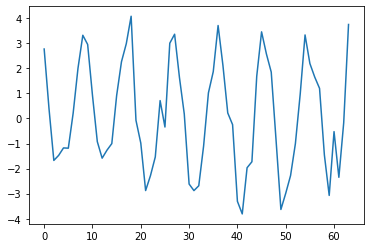

In [222]:
plt.plot(data1);

In [223]:
#data2 = pd.read_csv("2.txt", header=None)
#data2 = np.array(data2)
data2 = np.genfromtxt('2.txt', delimiter=',')

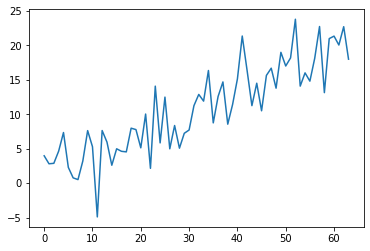

In [224]:
plt.plot(data2);

In [225]:
def find_weights(w):
    m = w // 2
    total = (w * np.sum(np.array(range(-m, m+1)) ** 4) - np.sum(np.array(range(-m, m+1)) ** 2)**2)/2
    pow0_coeff = np.sum(np.array(range(1, m+1)) ** 4)
    pow2_coeff = -np.sum(np.array(range(1, m+1)) ** 2)

    weights = list()

    for t in range(-m, m + 1):
        weights.append(pow0_coeff + pow2_coeff * t ** 2)

    return np.array(weights)/total

def WMA(data, w):
    weights = find_weights(w)
    m = w // 2
    wma = np.zeros(data.size)
    for i in range(0, m):
        min = i - m
        if min < 0:
            min = 0
        max = i + m
        if max > wma.size:
            max = wma.size
        max += 1
        wma[i] = np.sum(data[min:max]) / (max - min)

    for i in range(wma.size - m, wma.size):
        min = i - m
        if min < 0:
            min = 0
        max = i + m
        if max > wma.size:
            max = wma.size
        max += 1
        wma[i] = np.sum(data[min:max]) / (max - min)

    for i in range(m, wma.size - m):
        min = i - m
        max = i + m + 1
        wma[i] = np.sum(data[min:max] * weights)

    return wma

In [226]:
def SMA(data, w):
    m = w // 2
    sma = []
    omega = 1 / (2*m + 1)
    for i in range(data.size):
        sma.append(omega * np.sum(data[i-m:i+m+1]))
    return sma

In [234]:
def EMA(data, a):
    u0 = data[0]
    b = 1 - a
    ema = []
    ema.append(u0)
    for t in range(1, data.size):
        s = 0
        for j in range(t - 1):
            s += b**j * data[t-j]
        ema.append(a * s + b**t * u0)
    
    return ema

In [235]:
def DEMA(data, alpha, beta):
    l = [data[0]]
    b = [data[0]]
    dema = [data[0]]
    for t in range(1, data.size):
        l.append(alpha * data[t] + (1-alpha) * (l[t-1] + b[t-1]))
        b.append(beta * (l[t] - l[t-1]) + (1-beta) * b[t-1])
        dema.append(l[t] + b[t])
    return dema

In [279]:
def q_stat(trend):
    #trend = np.array(trend)
    trend = pd.Series(trend)
    m = 5
    n = trend.size
    q_st = 0
    for k in range(1, m+1):
        '''
        chisl = (n - k) * np.sum(trend[1:n-k] * trend[1+k:n+1])
        chisl -= np.sum(trend[1:n-k+1]) * np.sum(trend[1+k:n+1])
        
        znam = np.sqrt((n - k) * np.sum(trend[1:n-k+1]**2) - (np.sum(trend[1:n-k+1]))**2) * \
               np.sqrt((n - k) * np.sum(trend[1+k:n-k+1]**2) - (np.sum(trend[1+k:n+1]))**2)
        r = chisl / znam
        '''
        r = trend.autocorr(lag=k)
        
        q_st += r**2 / (n - k)
        
    q_st *= n * (n + 2)
    
    return q_st

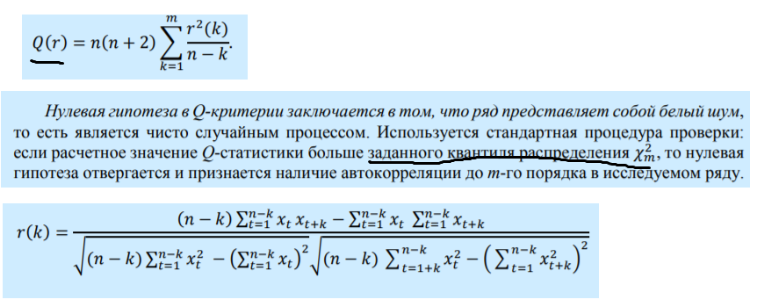

In [280]:
def darbin(x):
    x = np.array(x)
    d_l = 1.567
    d_u = 1.629
    n = x.size
    d = np.sum((x[2:n+1] - x[1:n-1]) ** 2) / np.sum(x[1:n+1] ** 2)
    print('d =', d)
    if (4 - d_u) > d > d_u:
        print('Гипотеза об отсутствии автокоррреляции первого порядка принимается.')
    if (d > (4 - d_l)) | (d < d_l):
        print('Гипотеза об отсутствии автокоррреляции первого порядка отвергается.')

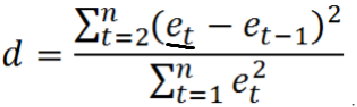

In [289]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [308]:
def get_trends(data):
    windows = [3, 5, 7, 9]
    prmtrs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # q = {q_stat: [params]}
    # SMA
    q = {}
    for w in windows:
        sma = SMA(data, w)
        q[q_stat(sma)] = w
    w_opt = q[min(q.keys())]
    print('SMA\nМинимальная Q_статистика: ', min(q.keys()), '\n Оптимальный размер окна: ', w_opt)
    darbin(SMA(data, w_opt))
    plt.plot(data)
    plt.plot(SMA(data, w_opt))
    plt.show();
    
    # WMA
    q = {}
    for w in windows:
        wma = WMA(data, w)
        q[q_stat(wma)] = w
    w_opt = q[min(q.keys())]
    print('WMA\nМинимальная Q_статистика: ', get_key(q, 7), '\n Оптимальный размер окна: ', 7)
    #print('WMA\nМинимальная Q_статистика: ', min(q.keys()), '\n Оптимальный размер окна: ', w_opt)
    darbin(WMA(data, w_opt))
    plt.plot(data)
    #plt.plot(WMA(data, w_opt))
    plt.plot(WMA(data, 7))
    plt.show();
    
    # EMA
    q = {}
    for a in prmtrs:
        ema = EMA(data, a)
        q[q_stat(ema)] = a
    a_opt = q[min(q.keys())]
    
    print('EMA\nМинимальная Q_статистика: ', min(q.keys()), '\n  Оптимальный параметр a: ', a_opt)
    darbin(EMA(data, a_opt))
    plt.plot(data)
    plt.plot(EMA(data, a_opt))
    plt.show();
    
    # DEMA
    q = {}
    for a in prmtrs:
        for b in prmtrs:
            dema = DEMA(data, a, b)
            q[q_stat(dema)] = [a, b]
        a_opt, b_opt = q[min(q.keys())]
    print('DEMA\nМинимальная Q_статистика: ', min(q.keys()), '\nОптимальные alpha и beta: ', a_opt, b_opt)
    darbin(DEMA(data, a_opt, b_opt))
    plt.plot(data)
    plt.plot(DEMA(data, a_opt, b_opt))
    plt.show();

SMA
Минимальная Q_статистика:  108.44928557697231 
 Оптимальный размер окна:  7
d = 0.3977767215075631
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


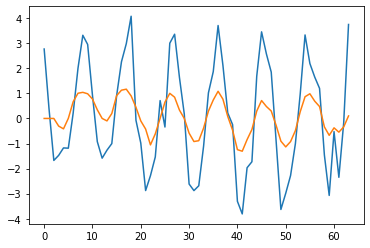

WMA
Минимальная Q_статистика:  162.01879119403938 
 Оптимальный размер окна:  7
d = 0.6408722701206672
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


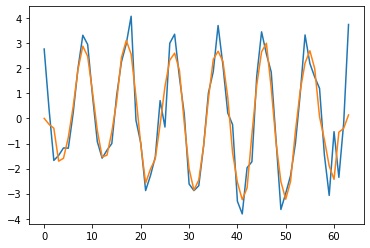

EMA
Минимальная Q_статистика:  88.09316820161382 
  Оптимальный параметр a:  0.2
d = 0.33995862395045207
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


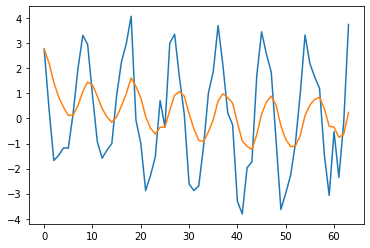

DEMA
Минимальная Q_статистика:  72.14379252849061 
Оптимальные alpha и beta:  0.5 0.1
d = 0.2805368027692876
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


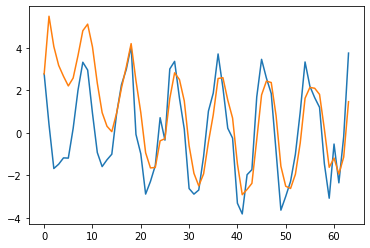

In [309]:
get_trends(data1)

SMA
Минимальная Q_статистика:  282.9772803925716 
 Оптимальный размер окна:  3
d = 0.021650905233367945
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


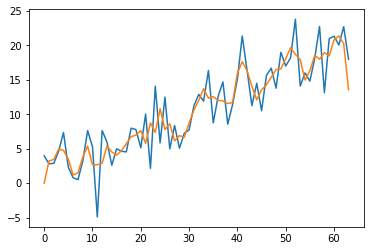

WMA
Минимальная Q_статистика:  287.60566544722207 
 Оптимальный размер окна:  7
d = 0.15642353703372872
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


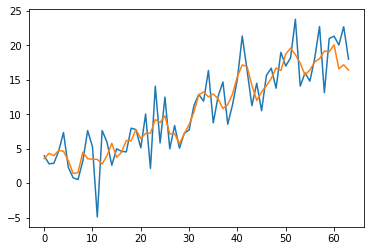

EMA
Минимальная Q_статистика:  208.92913814057653 
  Оптимальный параметр a:  0.9
d = 0.11044278717072864
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


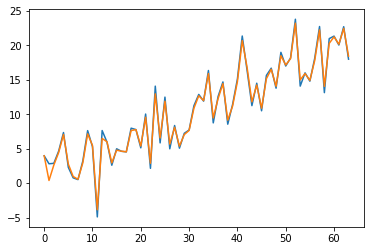

DEMA
Минимальная Q_статистика:  65.35701615310948 
Оптимальные alpha и beta:  0.9 0.9
d = 0.46179269910534837
Гипотеза об отсутствии автокоррреляции первого порядка отвергается.


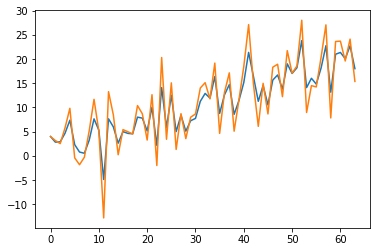

In [310]:
get_trends(data2)